## EDA and Data Cleaning

In [212]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [213]:
# Load data
df = pd.read_csv('SBAnational.csv')
# Display dimensions of the dataset
print(df.shape)

/var/folders/hs/r4ck14j54v17d80mrc1wt5kw0000gn/T/ipykernel_18635/3458774737.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


(899164, 27)


In [214]:
# Drop irrelevent columns
df_clean = df.drop(columns=[
    'LoanNr_ChkDgt',    
    'Name',             
    'City',             
    'Zip',
    'ChgOffDate',                  
    'ChgOffPrinGr',
    'BalanceGross',     
    'ApprovalFY'
])
print(df_clean.head())

  State                           Bank BankState   NAICS ApprovalDate  Term  \
0    IN               FIFTH THIRD BANK        OH  451120    28-Feb-97    84   
1    IN                1ST SOURCE BANK        IN  722410    28-Feb-97    60   
2    IN        GRANT COUNTY STATE BANK        IN  621210    28-Feb-97   180   
3    OK  1ST NATL BK & TR CO OF BROKEN        OK       0    28-Feb-97    60   
4    FL        FLORIDA BUS. DEVEL CORP        FL       0    28-Feb-97   240   

   NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural  \
0      4       2.0          0            0              1           0   
1      2       2.0          0            0              1           0   
2      7       1.0          0            0              1           0   
3      2       1.0          0            0              1           0   
4     14       1.0          7            7              1           0   

  RevLineCr LowDoc DisbursementDate DisbursementGross MIS_Status  \
0         N      Y

In [215]:
# Count missing values in each column
missing_counts = df_clean.isnull().sum().sort_values(ascending=False)
print("Missing proportion:\n", missing_counts/df.shape[0])

# Count rows with missing values
rows_with_missing = df_clean.isnull().any(axis=1).sum()
print(f"Porportion of rows with missing values: {rows_with_missing/df.shape[0]:.2%}")

# Drop rows with missing values
df_clean = df_clean.dropna()

# Check the size & missing values of df_clean
print("Cleaned dataset shape:", df_clean.shape)

Missing proportion:
 RevLineCr            0.005036
LowDoc               0.002872
DisbursementDate     0.002634
MIS_Status           0.002221
BankState            0.001742
Bank                 0.001734
NewExist             0.000151
State                0.000016
UrbanRural           0.000000
GrAppv               0.000000
DisbursementGross    0.000000
RetainedJob          0.000000
FranchiseCode        0.000000
CreateJob            0.000000
NoEmp                0.000000
Term                 0.000000
ApprovalDate         0.000000
NAICS                0.000000
SBA_Appv             0.000000
dtype: float64
Porportion of rows with missing values: 1.43%
Cleaned dataset shape: (886282, 19)


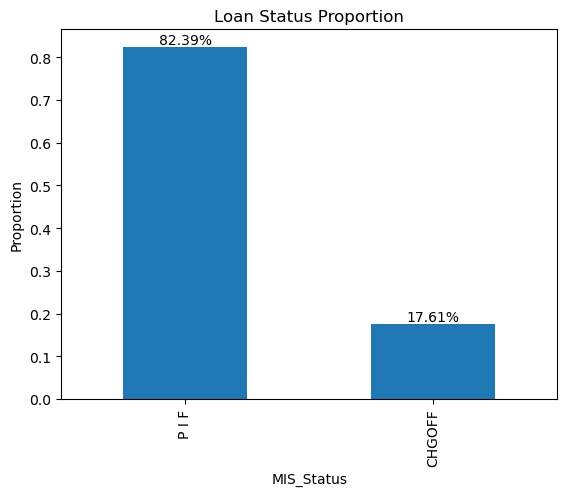

In [216]:
# Check the distribution of the target variable
status_counts = df_clean['MIS_Status'].value_counts(normalize=True)
status_counts.plot(kind='bar', title='Loan Status Proportion')

# Show plot
for i, v in enumerate(status_counts):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.ylabel('Proportion')
plt.show()

# Encode target variable
df_clean['MIS_Status'] = df_clean['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})

In [217]:
# Remove $ and , from monetary columns
monetary_cols = ['DisbursementGross','GrAppv', 'SBA_Appv']
for col in monetary_cols:
    df_clean[col] = df_clean[col].str.replace(r'[\$,]', '', regex=True)

# Convert all numeric columns to float 
num_cols = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',  'DisbursementGross', 'GrAppv', 'SBA_Appv']

for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [218]:
# Convert dates to datetime
df_clean['ApprovalDate'] = pd.to_datetime(df_clean['ApprovalDate'], format='%d-%b-%y', errors='coerce')
df_clean['DisbursementDate'] = pd.to_datetime(df_clean['DisbursementDate'], format='%d-%b-%y', errors='coerce')

# Disbursement lag
df_clean['DisbursementLag'] = (df_clean['DisbursementDate'] - df_clean['ApprovalDate']).dt.days

# IsFranchise:
df_clean['IsFranchise'] = (df_clean['FranchiseCode'] > 1).astype(int)

# Ratio: SBA guaranteed share portion
df_clean['SBA_Share'] = df_clean['SBA_Appv'] / df_clean['GrAppv']

# Convert NAICS code to first 2 digits
df_clean['NAICS'] = df_clean['NAICS'].astype(str).str[:2]

# Drop features used above
df_final = df_clean.drop(columns=[
    'FranchiseCode',        
    'SBA_Appv',           
    'GrAppv',             
    'ApprovalDate',       
    'DisbursementDate'    
])

numeric_feats = ['Term', 'NoEmp', 'DisbursementGross','DisbursementLag', 'SBA_Share', 'CreateJob', 'RetainedJob']

In [219]:
# Show proportion of NoEmp larger than 500
prop_noemp_large = (df_final['NoEmp'] > 500).mean()
print(f'Proportion of NoEmp larger than 500: {prop_noemp_large:.4f}')
# Drop NoEmp if larger than 500
df_final = df_final[df_final['NoEmp'] <= 500]

# Show proportion of NoEmp larger than 50
prop_noemp_large = (df_final['NoEmp'] > 50).mean()
print(f'Proportion of NoEmp larger than 50: {prop_noemp_large:.4f}')
# Drop NoEmp if larger than 50
df_final = df_final[df_final['NoEmp'] <= 50]

Proportion of NoEmp larger than 500: 0.0004
Proportion of NoEmp larger than 50: 0.0300


In [220]:
# Show proportion of DisbursementGross larger than 5000000
prop_disbursement_large = (df_final['DisbursementGross'] > 5000000).mean()
print(f'Proportion of DisbursementGross larger than 5000000: {prop_disbursement_large:.6f}')
# Drop rows with DisbursementGross larger than 5000000
df_final = df_final[df_final['DisbursementGross'] <= 5000000]

Proportion of DisbursementGross larger than 5000000: 0.000013


In [221]:
# Remove rows with negative disbursement lag
df_final = df_final[df_final['DisbursementLag'] >= 0]

# Remove rows DisbursementLag > 3650 (10 years)
df_final = df_final[df_final['DisbursementLag'] <= 3650]

In [222]:
# Count proportion of rows with CreateJob > 500
prop_cjob_large = (df_final['CreateJob'] > 500).mean()
print(f'Proportion of CreateJob larger than 500: {prop_cjob_large:.4f}')
# Drop rows with CreateJob > 500
df_final = df_final[df_final['CreateJob'] <= 500]

# Count proportion of rows with RetainedJob > 500
prop_rjob_large = (df_final['RetainedJob'] > 500).mean()
print(f'Proportion of RetainedJob larger than 500: {prop_rjob_large:.4f}')

Proportion of CreateJob larger than 500: 0.0007
Proportion of RetainedJob larger than 500: 0.0000


KeyboardInterrupt: 

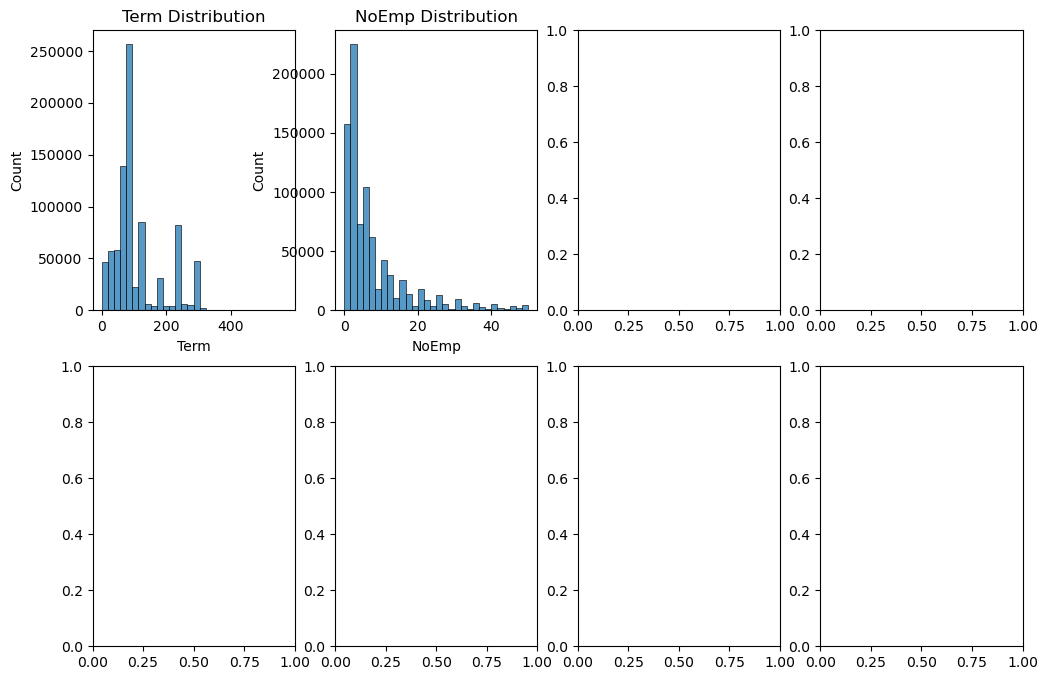

In [223]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
axes = axes.flatten()  # flatten to 1D for easy indexing

for i, col in enumerate(numeric_feats):
    sns.histplot(data=df_final, x=col, bins=30, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Check distribution of categorical variables
cat_feats = ['State', 'BankState', 'Bank', 'NAICS', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'IsFranchise']
df_final[cat_feats].nunique()

State            51
BankState        56
Bank           5744
NAICS            25
NewExist          3
UrbanRural        3
RevLineCr        18
LowDoc            8
IsFranchise       2
dtype: int64

In [ ]:
# Drop rows where NewExist is 0.0
df_final = df_final[df_final['NewExist'] != 0.0]

# For RevLineCr and LowDoc, retain Y and N only, others to 'Other'
df_final['RevLineCr'] = df_final['RevLineCr'].apply(lambda x: x if x in ['Y', 'N'] else 'Other')
df_final['LowDoc'] = df_final['LowDoc'].apply(lambda x: x if x in ['Y', 'N'] else 'Other')

# For NAICS, Combine 31/32/33, 44-45, 48-49
def combine_naics(code):
    if code in ['31', '32', '33']:
        return '31-33'
    elif code in ['44', '45']:
        return '44-45'
    elif code in ['48', '49']:
        return '48-49'
    else:
        return code
df_final['NAICS'] = df_final['NAICS'].apply(combine_naics)

/var/folders/hs/r4ck14j54v17d80mrc1wt5kw0000gn/T/ipykernel_18635/2152855971.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


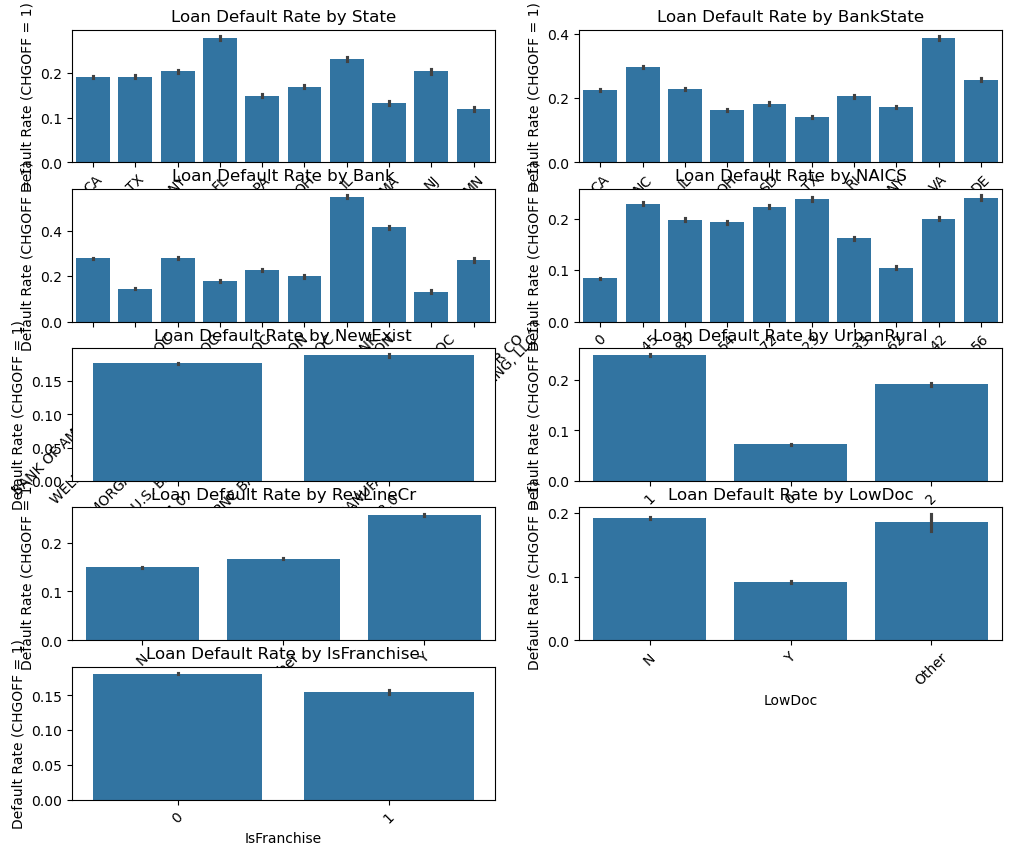

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))
axes = axes.flatten()  # flatten to use a single index

for i, col in enumerate(cat_feats[:10]):  # limit to 10 categorical features
    sns.barplot(
        data=df_final,
        x=col,
        y='MIS_Status',
        estimator=np.mean,
        order=df_final[col].value_counts().iloc[:10].index,
        ax=axes[i]
    )
    axes[i].set_title(f'Loan Default Rate by {col}')
    axes[i].set_ylabel("Default Rate (CHGOFF = 1)")
    axes[i].tick_params(axis='x', rotation=45)

# Hide any extra axes if len(cat_feats) < 10
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Top-K(20) Encoding for High Cardinality Categorical Features 
high_cardinality_feats = ['State', 'BankState', 'Bank']
for col in high_cardinality_feats:
        n_unique = df_final[col].nunique()
        if n_unique > 20:
            top_k = df_final[col].value_counts().nlargest(20).index 
            df_final[col] = df_final[col].apply(lambda x: x if x in top_k else "Other")
            print(f"Applied top-20 encoding to '{col}' ({n_unique} unique values).")

Applied top-20 encoding to 'State' (51 unique values).
Applied top-20 encoding to 'BankState' (56 unique values).
Applied top-20 encoding to 'Bank' (5741 unique values).


In [ ]:
# Display final dataset used for modeling
print(df_final.head(5))

   State                           Bank BankState  NAICS  Term  NoEmp  \
0     IN                          Other        OH  44-45    84      4   
1     IN                          Other     Other     72    60      2   
2     IN                          Other     Other     62   180      7   
3  Other                          Other     Other      0    60      2   
4     FL                          Other        FL      0   240     14   
5  Other  TD BANK, NATIONAL ASSOCIATION        DE  31-33   120     19   
6     NJ    WELLS FARGO BANK NATL ASSOC        SD      0    45     45   
7     FL                   REGIONS BANK        AL     81    84      1   
8     FL                          Other        FL     72   297      2   
9  Other                          Other     Other      0    84      3   

   NewExist  CreateJob  RetainedJob  UrbanRural RevLineCr LowDoc  \
0       2.0          0            0           0         N      Y   
1       2.0          0            0           0         N   

In [ ]:
# Display final dataset shape
print("Final dataset shape:", df_final.shape)

# Compute percentage of data lost
initial_rows = df.shape[0]
final_rows = df_final.shape[0]
data_lost_percentage = (initial_rows - final_rows) / initial_rows * 100
print(f"Percentage of data lost after cleaning: {data_lost_percentage:.2f}%")

Final dataset shape: (856992, 17)
Percentage of data lost after cleaning: 4.69%


After data cleaning, we have 883369 rows of data remaining, that is a 1.76% data loss compared with the original dataset.
After feature engineering, there are 7 numerical variables, 9 categorical variables, and 1 binary response.

## Model Training

In [ ]:
# Separate target
X = df_final.drop(columns=['MIS_Status'])
y = df_final['MIS_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_feats),
    ('cat', categorical_transformer, cat_feats)
])

In [ ]:
# Full pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric='logloss',
        random_state=663
    ))
])
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Term', 'NoEmp',
                                                   'DisbursementGross',
                                                   'DisbursementLag',
                                                   'SBA_Share', 'CreateJob',
                                                   'RetainedJob']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['State', 'BankState', 'Bank',
                                                   'NAICS', 'NewExist',
                                                   'UrbanRural', 'RevLineCr',
                                                   'Low...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=663
    ))
])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Term', 'NoEmp',
                                                   'DisbursementGross',
                                                   'DisbursementLag',
                                                   'SBA_Share', 'CreateJob',
                                                   'RetainedJob']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['State', 'BankState', 'Bank',
                                                   'NAICS', 'NewExist',
                                                   'UrbanRural', 'RevLineCr',
                                                   'LowDoc',
                                                   'IsFranchise'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=663))])

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logreg_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Term', 'NoEmp',
                                                   'DisbursementGross',
                                                   'DisbursementLag',
                                                   'SBA_Share', 'CreateJob',
                                                   'RetainedJob']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['State', 'BankState', 'Bank',
                                                   'NAICS', 'NewExist',
                                                   'UrbanRural', 'RevLineCr',
                                                   'LowDoc',
                                                   'IsFranchise'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=0.5,
        random_state=663
    ))
])
ada_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Term', 'NoEmp',
                                                   'DisbursementGross',
                                                   'DisbursementLag',
                                                   'SBA_Share', 'CreateJob',
                                                   'RetainedJob']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['State', 'BankState', 'Bank',
                                                   'NAICS', 'NewExist',
                                                   'UrbanRural', 'RevLineCr',
                                                   'LowDoc',
                                                   'IsFranchise'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.5, n_estimators=100,
                                    random_state=663))])

In [ ]:
from sklearn.metrics import classification_report

for name, model in zip(
    ["XGBoost", "Random Forest", "Logistic Regression", "AdaBoost"],
    [xgb_model, rf_model, logreg_model, ada_model]
):
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    140600
           1       0.86      0.73      0.79     30799

    accuracy                           0.93    171399
   macro avg       0.90      0.85      0.88    171399
weighted avg       0.93      0.93      0.93    171399


Random Forest Results:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    140600
           1       0.90      0.42      0.58     30799

    accuracy                           0.89    171399
   macro avg       0.90      0.71      0.76    171399
weighted avg       0.89      0.89      0.87    171399


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    140600
           1       0.73      0.37      0.49     30799

    accuracy                           0.86    171399
   macro avg       0.80      0.67      0.70    171399
we

## Model Evaluation

In [ ]:
# Predict using testing data
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

Model Evaluation on Test Set:
Precision: 0.9291322075662632
Recall: 0.931294815022258
Accuracy: 0.931294815022258
V-measure: 0.5033073103717021
Confusion Matrix:


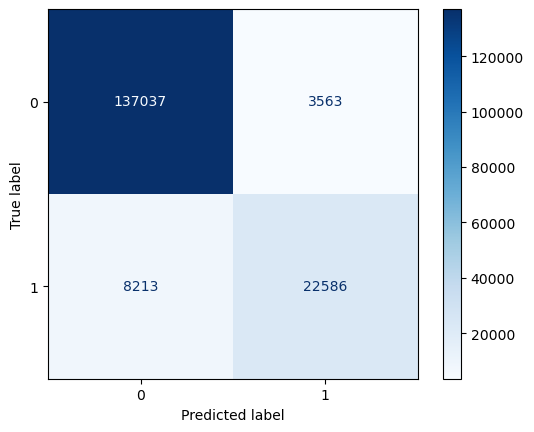

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, v_measure_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model evaluation 
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
v_measure = v_measure_score(y_test, y_pred)

print("Model Evaluation on Test Set:")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("V-measure:", v_measure)
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# display matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", values_format="d")
plt.show()

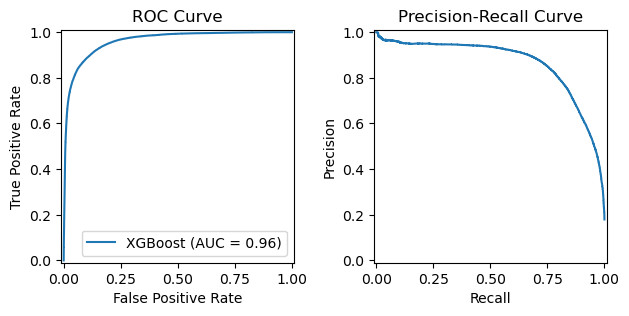

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

# metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# layout
fig, axs = plt.subplots(1, 2)

# ROC curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost').plot(ax=axs[0])
axs[0].set_title('ROC Curve')

# precision-recall curve
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axs[1])
axs[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

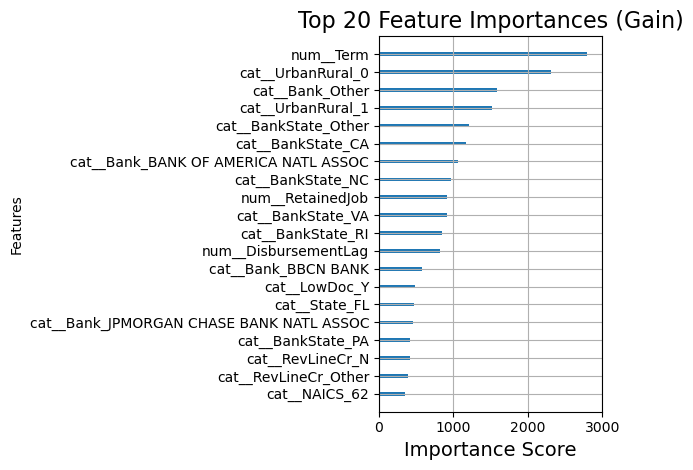

In [ ]:
from xgboost import plot_importance

booster = xgb_model.named_steps["classifier"]
feature_names = xgb_model.named_steps["preprocessor"].get_feature_names_out()
booster.get_booster().feature_names = feature_names.tolist()

plt.figure(figsize=(12, 12))
# top 20 features
plot_importance(
    booster, 
    importance_type='gain', 
    max_num_features=20, 
    show_values=False
) 
plt.title("Top 20 Feature Importances (Gain)", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.xlim(0, 3000) 
plt.grid(True)
plt.tight_layout()
plt.show()